# Setup

In [1]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
assert torch.cuda.is_available()

In [3]:
import sys
sys.path.append('../')
from data import LibriSpeechDataset, label_to_sex
from models import DilatedNet, ConvNet

In [4]:
n_seconds = 3
base_sampling_rate = 16000
downsampling = 4
batchsize = 8

# Get data

In [5]:
trainset = LibriSpeechDataset('train-clean-100',base_sampling_rate*n_seconds)
testset = LibriSpeechDataset('dev-clean',base_sampling_rate*n_seconds,stochastic=False)

Indexing data...
Finished indexing data. 27949 usable files found.
Indexing data...
Finished indexing data. 2303 usable files found.


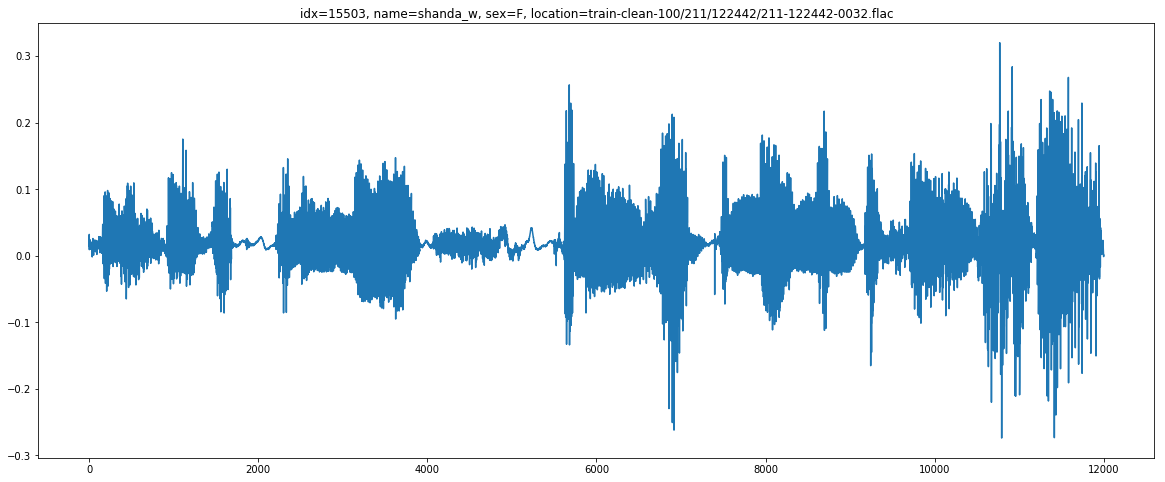

In [56]:
idx = np.random.randint(0,len(trainset))
instance, label = trainset[idx]

plt.figure(figsize=(20,8))
title_string = 'idx={}, name={}, sex={}, location={}'.format(
    idx,
    trainset.datasetid_to_name[idx],
    label_to_sex[label],
    '/'.join(trainset.datasetid_to_filepath[idx].split('/')[-4:])
)
plt.title(title_string)
plt.plot(instance[::downsampling])
plt.show()

In [7]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batchsize,num_workers=4,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=batchsize,num_workers=4,shuffle=True)

### Define model

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
# model = DilatedNet(128, 7, 1)
model = ConvNet(64, 7)
model.double()
model.cuda()

ConvNet(
  (initialconv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (initialbn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5)

In [18]:
count_parameters(model)

100161

In [19]:
def evaluate(dataloader=testloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            timeseries, labels = data
            if timeseries.shape[0] != batchsize:
                # incomplete batch
                continue
            timeseries = normalise(timeseries)
            timeseries = timeseries.reshape((batchsize,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
            predicted = model(timeseries)
            total += labels.size(0)
            correct += ((predicted > 0.5)[:,0] == labels.cuda().byte()).cpu().sum().numpy()
            
    return correct*1.0/total

In [20]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [21]:
torch.backends.cudnn.benchmark = True

In [22]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

In [23]:
# def normalise(instance,mean=0,rms=0.038021):
#     # default is mean RMS of first 3 seconds of every dev sample
#     instance = instance - instance.mean()
#     instance_rms = np.sqrt(np.square(instance)).mean()
#     return instance*(rms/instance_rms)

def normalise(batch,mean=0,rms=0.038021):
    m = batch.mean(dim=1)
    transform = batch-m.repeat([inputs.shape[1],1]).transpose(dim0=1,dim1=0)
    transform = transform*rms/torch.abs(transform).mean(dim=1).repeat([inputs.shape[1],1]).transpose(dim0=1,dim1=0)
    return transform

In [24]:
print_every = 100
best_accuracy = 0
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_correct_samples = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if inputs.shape[0] != batchsize:
            # incomplete batch
            continue
        
        inputs = normalise(inputs)
        inputs = inputs.reshape((batchsize,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
        
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape((batchsize,1)).cuda().double())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_correct_samples += torch.eq((outputs[:,0] > 0.5).cpu(), labels.byte()).numpy().sum()
        if i % print_every == print_every - 1:    # print every 'print_every' mini-batches
            val_acc = evaluate()
            
            # return model to training mode
            model.train()
            
            print('[%d, %5d] loss: %.3f acc: %.3f val_acc: %.3f' %
                  (epoch + 1, i + 1, 
                   running_loss / print_every, 
                   running_correct_samples*1. / (print_every*batchsize), 
                   val_acc))
            running_loss = 0.0
            running_correct_samples = 0
            
            # Save new model if its the best
            if val_acc > best_accuracy:
                print 'Saving new best model'
                torch.save(model.state_dict(),'../models/baseline.torch')
                best_accuracy = val_acc
                
            # Check for plateau
            scheduler.step(val_acc)

print('Finished Training')

[1,   100] loss: 0.456 acc: 0.801 val_acc: 0.927
Saving new best model
[1,   200] loss: 0.307 acc: 0.882 val_acc: 0.922
[1,   300] loss: 0.290 acc: 0.885 val_acc: 0.854
[1,   400] loss: 0.303 acc: 0.882 val_acc: 0.936
Saving new best model
[1,   500] loss: 0.308 acc: 0.875 val_acc: 0.937
Saving new best model
[1,   600] loss: 0.247 acc: 0.907 val_acc: 0.936
[1,   700] loss: 0.251 acc: 0.902 val_acc: 0.952
Saving new best model
[1,   800] loss: 0.219 acc: 0.919 val_acc: 0.950
[1,   900] loss: 0.236 acc: 0.921 val_acc: 0.955
Saving new best model
[1,  1000] loss: 0.234 acc: 0.910 val_acc: 0.954
[1,  1100] loss: 0.218 acc: 0.920 val_acc: 0.922
[1,  1200] loss: 0.236 acc: 0.917 val_acc: 0.951
[1,  1300] loss: 0.233 acc: 0.922 val_acc: 0.953
[1,  1400] loss: 0.285 acc: 0.896 val_acc: 0.959
Saving new best model
[1,  1500] loss: 0.219 acc: 0.926 val_acc: 0.958
[1,  1600] loss: 0.227 acc: 0.917 val_acc: 0.952
[1,  1700] loss: 0.241 acc: 0.912 val_acc: 0.934
[1,  1800] loss: 0.266 acc: 0.896 v

[5,  2800] loss: 0.129 acc: 0.956 val_acc: 0.974
[5,  2900] loss: 0.114 acc: 0.965 val_acc: 0.974
[5,  3000] loss: 0.130 acc: 0.944 val_acc: 0.977
[5,  3100] loss: 0.160 acc: 0.938 val_acc: 0.968
[5,  3200] loss: 0.120 acc: 0.955 val_acc: 0.976
[5,  3300] loss: 0.159 acc: 0.941 val_acc: 0.975
[5,  3400] loss: 0.110 acc: 0.960 val_acc: 0.974
Finished Training


In [26]:
loss

tensor(1.00000e-02 *
       2.5780, dtype=torch.float64, device='cuda:0')

# Error analysis
Accuracy by speaker. Are some speakers harder to classify than others?

In [9]:
model = ConvNet(64, 7)
model.load_state_dict(torch.load('../models/baseline.torch'))
model.double()
model.cuda()

ConvNet(
  (initialconv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (initialbn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5)

In [10]:
model.eval()

ConvNet(
  (initialconv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (initialbn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5)

In [11]:
from utils import normalise

In [12]:
def len_silence(instance,n_smooth=16,silence_threshold=5e-3):
    """This function attempts to tell how much silence in a normalised sample"""
    smoothed = np.convolve(abs(instance), np.ones((n_smooth,))/n_smooth, mode='valid')
    return len(smoothed[smoothed < silence_threshold])

In [13]:
df = []
for i in tqdm(range(len(testset))):
    instance, label = testset[i]
    instance = normalise(instance)
    instance_cuda = torch.from_numpy(instance.reshape(1,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
    with torch.no_grad():
        pred = model(instance_cuda)[0][0].cpu().numpy()
    df.append({
        'i': i,
        'name': testset.datasetid_to_name[i],
        'sex': label_to_sex[label],
        'rms': np.sqrt(np.square(instance)).mean(),
        'rmedians': np.median(np.sqrt(np.square(instance))),
        'rsums': np.sum(np.sqrt(np.square(instance))),
        'mean': np.mean(instance),
        'pred':pred,
        'label': label,
        'silence': len_silence(instance)
    })
df = pd.DataFrame(df)

In [14]:
df = df.assign(
    error=abs(df['pred'].astype(float)-df['label'].astype(int)),
    label=df['label'].astype(int),
    correct=(df['pred'] > 0.5) == df['label'],
    pred=df['pred'].astype(float)
)

In [15]:
df[['i','name','pred','label','error','correct','silence']]

,i,name,pred,label,error,correct,silence
0,0,Renata,0.995141,1,0.004859,True,7975
1,1,Renata,0.984229,1,0.015771,True,3299
2,2,Renata,0.982865,1,0.017135,True,2838
3,3,Renata,0.956680,1,0.043320,True,2672
4,4,Renata,0.983996,1,0.016004,True,6188
5,5,Renata,0.974326,1,0.025674,True,3343
6,6,Renata,0.921079,1,0.078921,True,6430
7,7,Renata,0.993152,1,0.006848,True,5272
8,8,Renata,0.984461,1,0.015539,True,5919
9,9,Renata,0.982645,1,0.017355,True,3176


In [16]:
df.groupby('correct').agg({'i': 'count'})

,i
correct,
False,45
True,2258


In [17]:
gb = df.groupby('name').agg({'error': ['mean','max'], 'pred': 'mean', 'label': 'mean', 'silence': ['mean', 'max']})
gb.columns = ['.'.join(col).strip() for col in gb.columns.values]
gb.sort_values('error.mean',ascending=False)

,pred.mean,label.mean,silence.mean,silence.max,error.mean,error.max
name,,,,,,
Kathy Caver,0.576646,1,10522.150000,21577,0.423354,0.945062
Stephen Kinford,0.211845,0,15805.500000,24830,0.211845,0.919738
Peter Eastman,0.202367,0,15315.117647,21512,0.202367,0.988527
Nicodemus,0.120291,0,18999.980000,27075,0.120291,0.902798
President Lethe,0.091360,0,10322.696970,18268,0.091360,0.497722
dexter,0.088361,0,13526.638889,20167,0.088361,0.447983
JudyGibson,0.915639,1,11303.871795,19319,0.084361,0.783745
Jennifer Wiginton,0.928182,1,13009.527027,20650,0.071818,0.868324
Ransom,0.932313,1,14706.163934,31439,0.067687,0.876208


In [18]:
df[df['name']=='Kathy Caver'][['name','pred','correct','error','sex']]

,name,pred,correct,error,sex
1064,Kathy Caver,0.874826,True,0.125174,F
1065,Kathy Caver,0.795378,True,0.204622,F
1066,Kathy Caver,0.862807,True,0.137193,F
1067,Kathy Caver,0.389398,False,0.610602,F
1068,Kathy Caver,0.692482,True,0.307518,F
1069,Kathy Caver,0.800360,True,0.199640,F
1070,Kathy Caver,0.295695,False,0.704305,F
1071,Kathy Caver,0.631863,True,0.368137,F
1072,Kathy Caver,0.146731,False,0.853269,F
1073,Kathy Caver,0.515693,True,0.484307,F


### Test time augmentation

### Adding more seconds of audio

In [ ]:
# What's the accuracy for the mean of two random samples

In [72]:
data = []
for n_samples in range(1,25):
    correct = 0
    for _ in xrange(2500):
        combined_pred = df[df['name']=='Kathy Caver'].sample(n_samples)['pred'].mean()
        correct += int(combined_pred > 0.5)

    print n_samples, correct*1./2500
    data.append((n_samples, correct*1./2500))

1 0.6684
2 0.6996
3 0.7092
4 0.7468
5 0.7624
6 0.7816
7 0.8228
8 0.8228
9 0.8672
10 0.8592
11 0.8736
12 0.9036
13 0.9072
14 0.9296
15 0.9344
16 0.9396
17 0.9484
18 0.9624
19 0.9724
20 0.9736
21 0.9812
22 0.986
23 0.9892
24 0.9908


In [73]:
data = np.array(data)

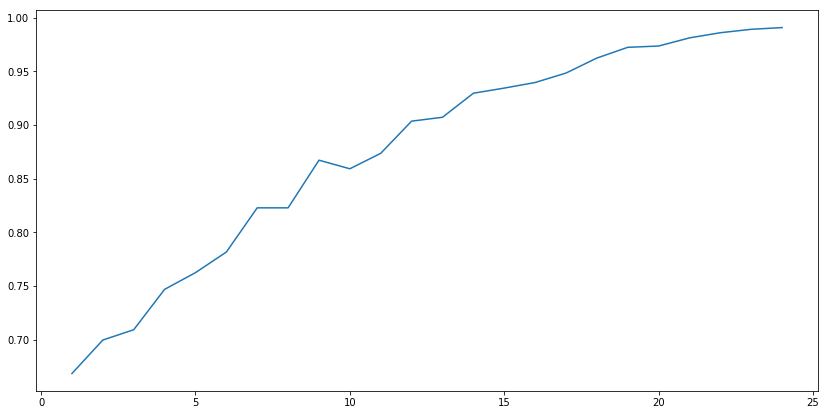

In [92]:
plt.figure(figsize=(14,7))
plt.plot(data[:,0],data[:,1])
# plt.ylim(0,1)
plt.show()

# Attempt to find incorrect labels in the training set

In [79]:
dftrain = []
for i in tqdm(range(len(trainset))):
    instance, label = trainset[i]
    instance = normalise(instance)
    instance_cuda = torch.from_numpy(instance.reshape(1,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
    with torch.no_grad():
        pred = model(instance_cuda)[0][0].cpu().numpy()
    dftrain.append({
        'i': i,
        'name': trainset.datasetid_to_name[i],
        'sex': label_to_sex[label],
        'rms': np.sqrt(np.square(instance)).mean(),
        'rmedians': np.median(np.sqrt(np.square(instance))),
        'rsums': np.sum(np.sqrt(np.square(instance))),
        'mean': np.mean(instance),
        'pred':pred,
        'label': label
    })
dftrain = pd.DataFrame(dftrain)

In [80]:
dftrain = dftrain.assign(
    error=abs(dftrain['pred'].astype(float)-dftrain['label'].astype(int)),
    label=dftrain['label'].astype(int),
    correct=(dftrain['pred'] > 0.5) == dftrain['label'],
    pred=dftrain['pred'].astype(float)
)

In [81]:
dftrain.groupby('correct').agg({'i': 'count'})

,i
correct,
False,809
True,27140


In [82]:
gb = dftrain.groupby('name').agg({'error': ['mean','max'], 'pred': 'mean', 'label': 'mean'})
gb.columns = ['.'.join(col).strip() for col in gb.columns.values]
gb.sort_values('error.mean',ascending=False)

,pred.mean,label.mean,error.mean,error.max
name,,,,
Deborah Knight,0.481116,1,0.518884,0.980667
Rowdy Delaney,0.425166,0,0.425166,0.947771
Kathy Wright,0.592768,1,0.407232,0.995125
Daryl Wor,0.607832,1,0.392168,0.998760
kumarei,0.355998,0,0.355998,0.973025
Ellen Jones,0.651638,1,0.348362,0.965554
Donna Stewart,0.655520,1,0.344480,0.995669
Adam Picot,0.332170,0,0.332170,0.959717
Canby Ibarra,0.329437,0,0.329437,0.970886


In [83]:
dftrain[dftrain['name']=='Deborah Knight'][['name','i','pred','label','error','correct','sex']].sort_values('error')

,name,i,pred,label,error,correct,sex
23832,Deborah Knight,23832,0.993263,1,0.006737,True,F
23865,Deborah Knight,23865,0.973820,1,0.026180,True,F
23783,Deborah Knight,23783,0.973122,1,0.026878,True,F
23836,Deborah Knight,23836,0.948676,1,0.051324,True,F
23827,Deborah Knight,23827,0.942996,1,0.057004,True,F
23867,Deborah Knight,23867,0.941973,1,0.058027,True,F
23840,Deborah Knight,23840,0.933464,1,0.066536,True,F
23857,Deborah Knight,23857,0.928617,1,0.071383,True,F
23856,Deborah Knight,23856,0.925518,1,0.074482,True,F
23804,Deborah Knight,23804,0.925048,1,0.074952,True,F


# Run this model against a sample of my own voice

In [19]:
import soundfile as sf

In [20]:
voice, sampling_rate = sf.read('/home/oscar/Downloads/oscar.flac')

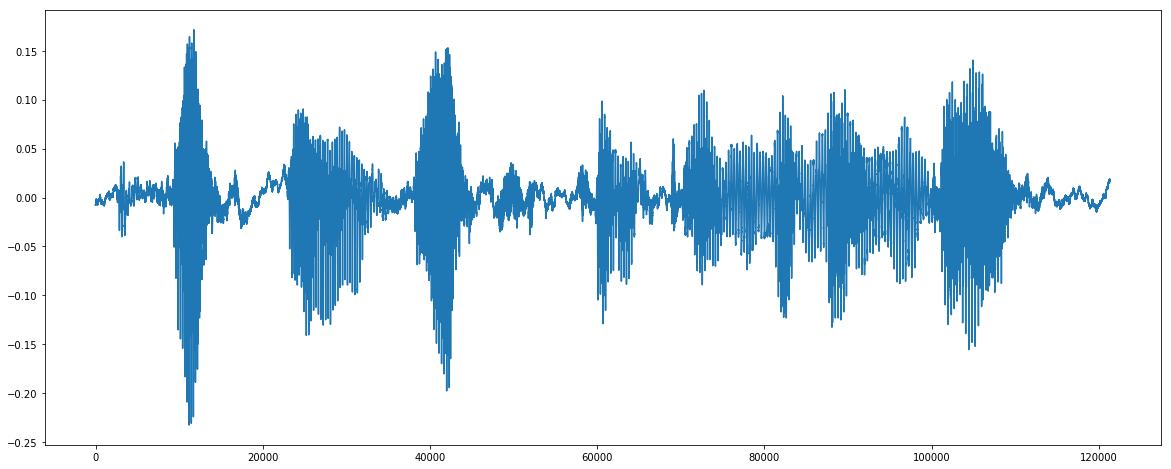

In [21]:
plt.figure(figsize=(20,8))
plt.plot(voice.sum(axis=1))
plt.show()

In [64]:
voice.shape[0]/sampling_rate

2.75156462585034

In [22]:
mono_voice = voice.sum(axis=1)

In [31]:
from scipy.signal import resample

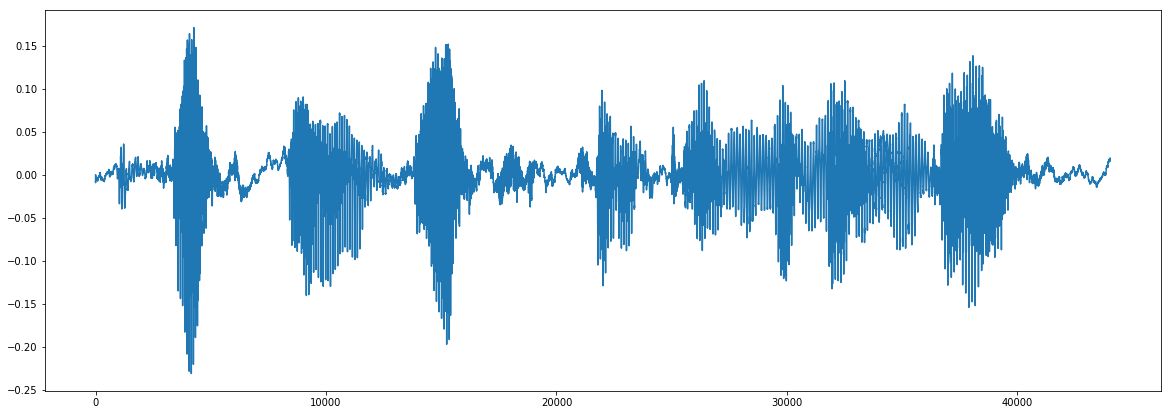

In [39]:
plt.figure(figsize=(20,7))
plt.plot(resample(mono_voice, int(mono_voice.shape[0]*base_sampling_rate/sampling_rate)))
plt.show()

In [47]:
instance_cuda.shape

torch.Size([1, 1, 12000])

In [41]:
downsampled_mono_voice = resample(mono_voice, int(mono_voice.shape[0]*base_sampling_rate/sampling_rate))

In [67]:
model(
    torch.from_numpy(downsampled_mono_voice).cuda().reshape((1, 1, -1))
).item()

0.03384122629701241

In [50]:
from data import label_to_sex

In [51]:
label_to_sex

{False: 'M', True: 'F'}

# Notes

In [ ]:
evaluate()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

In [ ]:
for s in range(1,4):
    for i in range(3,9):
        m = DilatedNet(128, i, s)
        print s, i, 3**i, s*(3**i), count_parameters(m)

In [ ]:
conv = ConvNet(128, 8)

In [ ]:
count_parameters(conv)

In [ ]:
3**8